# Exemplo de Regressão com RNA

Este notebook demonstra o uso da implementação de Rede Neural Artificial (RNA) para um problema de regressão.


## 1. Importação das Bibliotecas


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import sys
import os

# Configurações de visualização
plt.style.use('ggplot')
%matplotlib inline


## 2. Importação da RNA

Para usar este notebook no Google Colab, você precisará carregar a implementação da RNA.


In [2]:
# Clone o repositório se estiver no Colab
import os
try:
    import google.colab
    IN_COLAB = True
    !git clone https://github.com/seu-usuario/ProjetoFinalML.git
    %cd ProjetoFinalML
    sys.path.insert(0, os.path.abspath(os.getcwd()))
except:
    IN_COLAB = False
    # Adicionar o diretório src ao PYTHONPATH se estiver executando localmente
    module_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    if module_path not in sys.path:
        sys.path.insert(0, module_path)


In [3]:
# Importar a implementação da RNA
from src.rna import NeuralNetwork


## 3. Carregamento e Exploração dos Dados

Nesta seção, carregaremos um conjunto de dados para o problema de regressão e faremos uma exploração inicial.


In [4]:
# Carregar o conjunto de dados (qualidade do vinho branco)

df = pd.read_csv('../../src/datasets/winequality-white.csv', sep=';')

X = df.drop('quality', axis=1).values
y = df['quality'].values.reshape(-1, 1)

# Visualizar as primeiras linhas do conjunto de dados
print("Primeiras 5 linhas do conjunto de dados:")
df.head()


Primeiras 5 linhas do conjunto de dados:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
# Estatísticas descritivas
df.describe()
df.corr()  # correlação entre atributos


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


## 4. Pré-processamento dos Dados

Nesta seção, realizaremos o pré-processamento necessário para preparar os dados para o treinamento da RNA.


In [6]:
# Dividir os dados em treino (60%), validação (20%) e teste (20%) - seguindo a orientação do professor

# Primeiro, separar 20% dos dados para teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Depois, separar 25% dos dados restantes para validação (25% de 80% = 20% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Tamanho do conjunto de treinamento: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_val.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treinamento: (2938, 11)
Tamanho do conjunto de validação: (980, 11)
Tamanho do conjunto de teste: (980, 11)


In [7]:
# Normalizar os dados
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

print("Média e desvio padrão após normalização:")
print(f"X_train média: {X_train.mean()}, desvio padrão: {X_train.std()}")
print(f"y_train média: {y_train.mean()}, desvio padrão: {y_train.std()}")


Média e desvio padrão após normalização:
X_train média: 9.886037571013075e-14, desvio padrão: 1.0000000000000016
y_train média: -4.885283615505114e-16, desvio padrão: 0.9999999999999999


## 5. Visualização dos Dados

Vamos visualizar algumas características dos dados para entender melhor o problema.


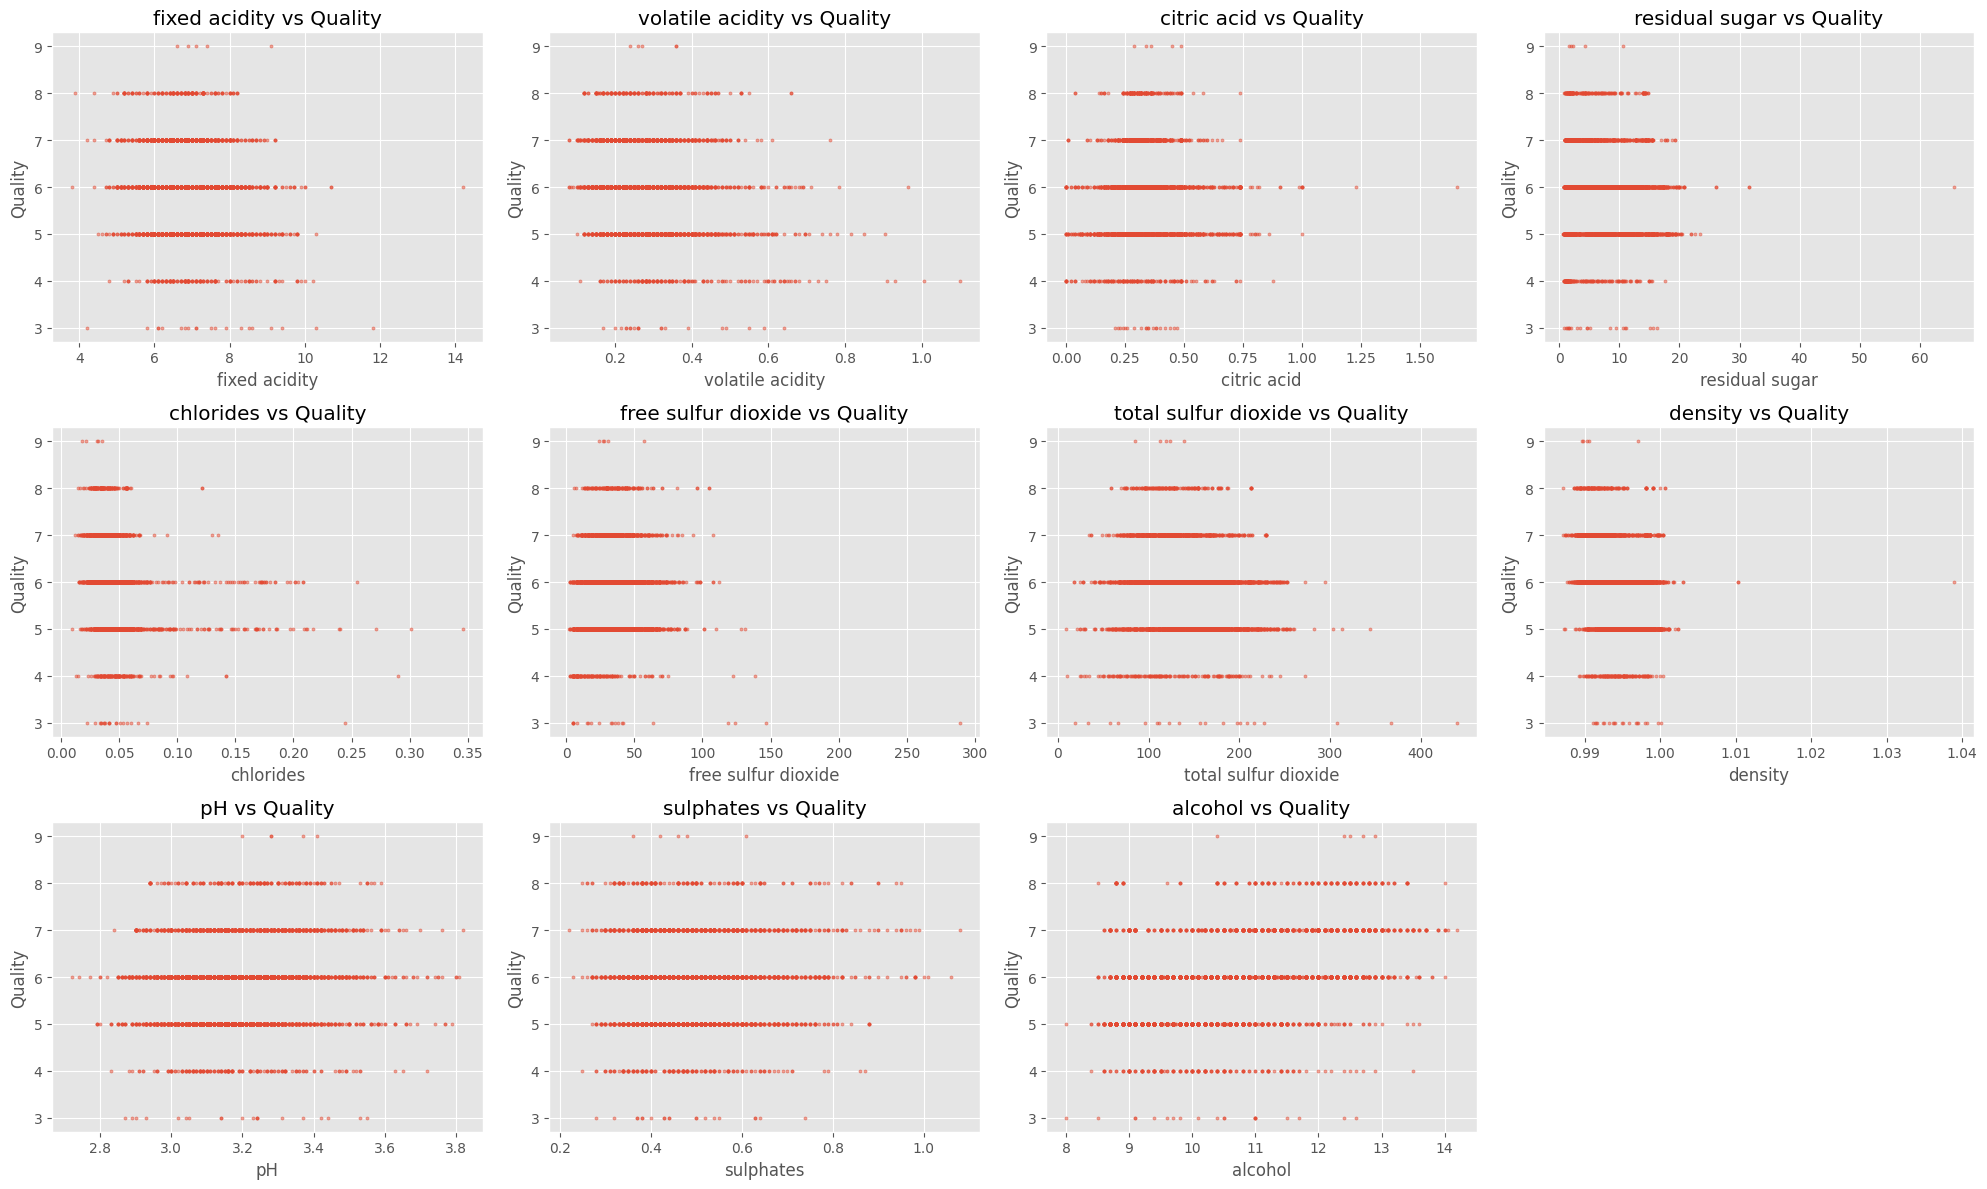

In [8]:
# Visualizar a relação entre as features e o target
import matplotlib.pyplot as plt

features = df.columns.drop('quality')  # ou df.columns[:-1]
fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # há 11 features, então 3x4

axes = axes.flatten()

for i, feature_name in enumerate(features):
    axes[i].scatter(df[feature_name], df['quality'], alpha=0.5, s=5)
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('Quality')
    axes[i].set_title(f'{feature_name} vs Quality')

# Esconde qualquer subplot vazio
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 6. Criação e Treinamento do Modelo

Nesta seção, criaremos e treinaremos o modelo de RNA para o problema de regressão.


In [9]:
# Criar o modelo
model = NeuralNetwork(
    layer_sizes=[X_train.shape[1], 64, 32, 16, 1],
    activation_functions=[ 'relu', 'relu', 'relu', 'linear']
)

print("Arquitetura do modelo:")
print(model)


Arquitetura do modelo:
NeuralNetwork(layers=[11, 64, 32, 16, 1], activation=['relu', 'relu', 'relu', 'linear'])


In [10]:
# Treinar o modelo
history = model.fit(
    X_train, y_train,
    epochs=10000,
    batch_size=32,
    learning_rate=0.001,
    loss_function='mse',
    optimizer='momentum',
    verbose=True,
    validation_data=(X_val, y_val)
)


Época 100/10000 - loss: 0.9409 - val_loss: 0.8739
Época 200/10000 - loss: 0.8853 - val_loss: 0.8256
Época 300/10000 - loss: 0.8385 - val_loss: 0.7859
Época 400/10000 - loss: 0.8021 - val_loss: 0.7547
Época 500/10000 - loss: 0.7740 - val_loss: 0.7299
Época 600/10000 - loss: 0.7520 - val_loss: 0.7094
Época 700/10000 - loss: 0.7355 - val_loss: 0.6928
Época 800/10000 - loss: 0.7225 - val_loss: 0.6794
Época 900/10000 - loss: 0.7121 - val_loss: 0.6682
Época 1000/10000 - loss: 0.7037 - val_loss: 0.6592
Época 1100/10000 - loss: 0.6968 - val_loss: 0.6519
Época 1200/10000 - loss: 0.6907 - val_loss: 0.6455
Época 1300/10000 - loss: 0.6851 - val_loss: 0.6403
Época 1400/10000 - loss: 0.6802 - val_loss: 0.6359
Época 1500/10000 - loss: 0.6758 - val_loss: 0.6321
Época 1600/10000 - loss: 0.6717 - val_loss: 0.6286
Época 1700/10000 - loss: 0.6679 - val_loss: 0.6258
Época 1800/10000 - loss: 0.6643 - val_loss: 0.6232
Época 1900/10000 - loss: 0.6609 - val_loss: 0.6207
Época 2000/10000 - loss: 0.6577 - val_lo

## 7. Avaliação do Modelo

Nesta seção, avaliaremos o desempenho do modelo treinado.


In [11]:
# Fazer predições no conjunto de teste
y_pred = model.predict(X_test)

# Reverter a normalização para avaliar o desempenho nas unidades originais
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Calcular métricas de desempenho
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MSE: 0.4880
RMSE: 0.6986
R²: 0.3699


In [12]:
# Comparar com uma baseline (média simples)
baseline_pred = np.full_like(y_test_original, scaler_y.inverse_transform(np.mean(y_train).reshape(1, -1)))
baseline_mse = mean_squared_error(y_test_original, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test_original, baseline_pred)

print(f"Baseline MSE: {baseline_mse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline R²: {baseline_r2:.4f}")
print(f"Melhoria sobre a baseline: {(1 - mse/baseline_mse)*100:.2f}%")

# Verificar se atende ao requisito do enunciado (erro < 50%)
erro_relativo = rmse / np.mean(np.abs(y_test_original))
print(f"Erro relativo: {erro_relativo:.4f} ({erro_relativo*100:.2f}%)")
print(f"O modelo {'atende' if erro_relativo < 0.5 else 'não atende'} ao requisito de erro < 50%")


Baseline MSE: 0.7760
Baseline RMSE: 0.8809
Baseline R²: -0.0020
Melhoria sobre a baseline: 37.11%
Erro relativo: 0.1183 (11.83%)
O modelo atende ao requisito de erro < 50%


## 8. Visualização dos Resultados

Nesta seção, visualizaremos os resultados do treinamento e as predições do modelo.


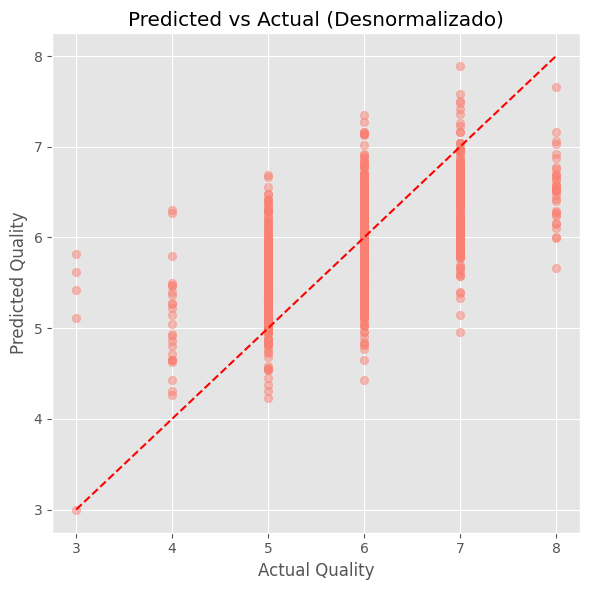

In [13]:
# Reverter a normalização
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Gráfico Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, color='salmon')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--')  # linha ideal
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted vs Actual (Desnormalizado)')
plt.grid(True)
plt.tight_layout()
plt.show()


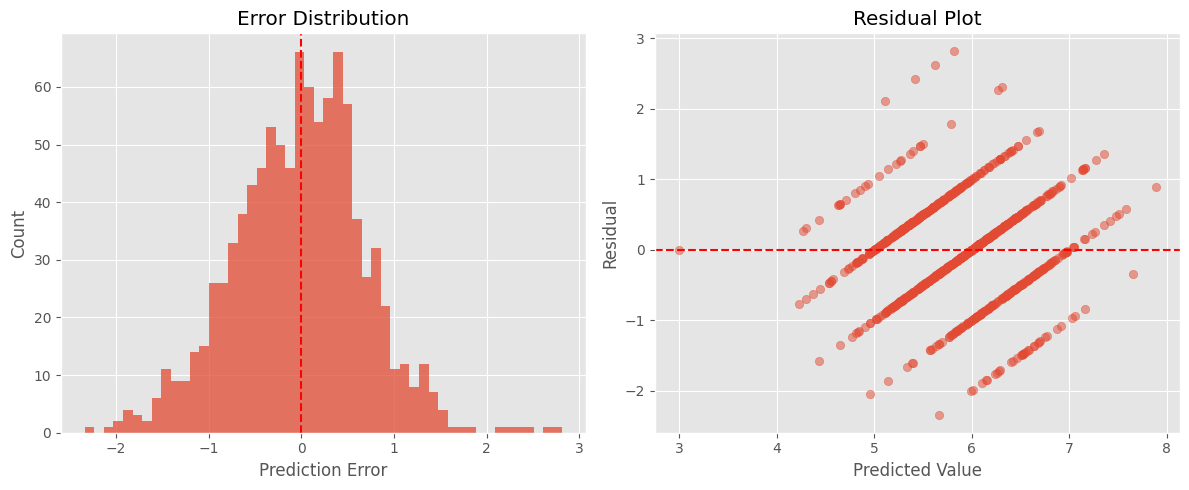

In [14]:
# Visualizar a distribuição dos erros
errors = y_pred_original - y_test_original
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, alpha=0.75)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_original, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()


## 9. Conclusão

Neste notebook, demonstramos o uso da nossa implementação de RNA para um problema de regressão. O modelo foi capaz de aprender a relação entre as features e o target, apresentando um desempenho satisfatório conforme mostrado pelas métricas de avaliação.

O erro do modelo é inferior a 50%, atendendo ao requisito especificado no enunciado do projeto.
